# Emission Intensity

This notebook shows how to create a chart similar to the infographics [Emission intensities of economies](https://faktaoklimatu.cz/infografiky/emisni-intenzity):

![Emission intensities of economies](https://faktaoklimatu.cz/assets/infographics/emisni-intenzity_1200.png)

The chart is very complex – it shows:
- greenhouse gases emissions per GDP along x-axis (g CO2eq / \$) – this is called **emission intensity of the economy**
- GDP per capita along y-axis (\$ per capita, expressed in constant international 2011 dollars)
- the product of x-value and y-value is emissions per capita – so countries with the same level of emissions per capita are along the same hyperbola (expressed in tonnes of CO2eq per capita per year)
- the sizes of bubbles correspond to total population, color coding shows different continents

More detailed description (in Czech only) can be found on the page showing this infographic.

## Load prerequisities

It is necessary to install all the required packages before the first use (and it has to be done only once for all notebooks). Then we can import the libraries (and set up better plotting settings via matplotlibrc file).

In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc_file_defaults()
import world_bank_data as wb

## Prepare the dataset

The chart combines three variables:
- population
- sizes of economics (GDP)
- greenhouse gases emissions

In addition, we need labels for all countries and information in what regions the countries are located. The most recent greenhouse gas emissions data are available for 2015, so we need all data sources only for this year.

The final dataset is stored under `data/world-emissions-2015-regions.csv`, so you can skip the preparation and go straight to plotting if you wish.

### Population data

The population data is loaded from World Bank via their [python library](https://pypi.org/project/world-bank-data/). The population data is stored under `SP.POP.TOTL` identifier. The World Bank uses ISO 3166 alpha-3 as country identifiers.

In [2]:
pop_raw = wb.get_series('SP.POP.TOTL', id_or_value='id')

In [3]:
pop = pop_raw.reset_index().query('Year == "2015"')[['Country', 'SP.POP.TOTL']].rename(columns={'Country': 'code', 'SP.POP.TOTL': 'pop'})
pop = pop[np.isfinite(pop['pop'])]  # there are two countries with no population data
pop['pop'] = np.int_(pop['pop'])
pop = pop.sort_values('code').reset_index(drop=True)

In [4]:
pop.head()

,code,pop
0,ABW,104341
1,AFG,34413603
2,AGO,27884381
3,ALB,2880703
4,AND,78011


### GDP data

GDP data is loaded from World Bank too. We use `NY.GDP.MKTP.PP.KD` series, containing GDP PPP, constant 2017 international \$.

In [5]:
gdp_raw = wb.get_series('NY.GDP.MKTP.PP.KD', id_or_value='id')

In [6]:
gdp = gdp_raw.reset_index().query('Year == "2015"')[['Country', 'NY.GDP.MKTP.PP.KD']] \
    .rename(columns={'Country': 'code', 'NY.GDP.MKTP.PP.KD': 'gdp'}) \
    .sort_values('code') \
    .reset_index(drop=True)

In [7]:
gdp.head()

,code,gdp
0,ABW,3.889424e+09
1,AFG,7.614873e+10
2,AGO,2.240904e+11
3,ALB,3.493121e+10
4,AND,NaN


The World Bank changed this particular series recently. It used to contain data expressed in constant 2011 international \\$ and our infographic is based on this older version. The comparison of different countries is slightly changed with the updated GDP data (overall results are preserved of course). If you would like to get identical chart to our infographic, you can load the GDP data in constant 2011 international \\$ from `data/world-bank/NY.GDP.MKTP.PP.KD.2011.csv`.

In [ ]:
# gdp = pd.read_csv('../data/world-bank/NY.GDP.MKTP.PP.KD.2011.csv', skiprows=3)[['Country Code', '2015']] \
#     .rename(columns={'Country Code': 'code', '2015': 'gdp'})

### Greenhouse gases emissions data

The World Bank publishes emissions data too, in series `EN.ATM.GHGT.KT.CE`. Unfortunately the series does not contain newer data than 2012, so it is better to use a specialized EDGAR database provided by Joint Research Centre of European Commission. EDGAR stands for Emissions Database for Global Atmospheric Research and the newest data is published under [EDGAR v5.0](https://edgar.jrc.ec.europa.eu/overview.php?v=50_GHG). The link is frequently unavailable, so we downloaded the emission data files into `data\edgar\v5.0`. EDGAR also provides more [detailed description](https://edgar.jrc.ec.europa.eu/overview.php?v=50_readme) of the dataset.

We will use three XLS files from `data\edgar\v5.0`:
- `v50_CO2_excl_short-cycle_org_C_1970_2018.xls` – CO2 emissions, excluding short cycles, for 1970–2018
- `v50_CH4_1970_2015.xls` – CH4 emissions for 1970–2015
- `v50_N2O_1970_2015.xls` – NO2 emissions for 1970–2015

Conversion to CO2 equivalent is based on [IPCC AR5](https://www.ipcc.ch/assessment-report/ar5/), with coefficients 28 for CH4 and 265 for NO2. The total emissions do not include some marginal greenhouse gases as these are not provided in EDGAR. The values are in Gg (Gigagrams), i.e. thousand tonnes.

In [8]:
ghgs = ['CO2', 'CH4', 'N2O']
edgar_files = ['CO2_excl_short-cycle_org_C', 'CH4', 'N2O']
edgar = None

for gas in ghgs:
    ef = 'CO2_excl_short-cycle_org_C' if gas == 'CO2' else gas
    ey = 2018 if gas == 'CO2' else 2015
    filename = f'../data/edgar/v5.0/v50_{ef}_1970_{ey}.xls'
    frame = pd.read_excel(filename, sheet_name='TOTALS BY COUNTRY', header=9)
    frame = frame[['ISO_A3'] + list(range(1970, ey + 1))].rename(columns={'ISO_A3': 'code'}).set_index('code')
    frame.columns = frame.columns.rename('year')
    frame = frame.unstack().rename(gas).reset_index()
    frame = frame[~frame['code'].isin(['SEA', 'AIR'])]
    if edgar is None:
        edgar = frame
    else:
        edgar = pd.merge(edgar, frame, how='outer')

In [9]:
edgar.head()

,year,code,CO2,CH4,N2O
0,1970,CAN,3.615930e+05,4067.309419,79.336936
1,1970,SPM,3.968802e+01,0.156984,0.002455
2,1970,USA,4.688522e+06,26548.904490,990.503415
3,1970,MEX,1.212967e+05,4636.361332,70.342887
4,1970,ABW,2.129258e+01,0.577072,0.005510


In [10]:
ghg = edgar.query('year == 2015').drop(columns=['year']).sort_values('code').reset_index(drop=True)
ghg['ghg'] = ghg['CO2'] + 28 * ghg['CH4'] + 265 * ghg['N2O']

In [11]:
ghg.head()

,code,CO2,CH4,N2O,ghg
0,ABW,959.583023,0.961202,0.051644,1000.182387
1,AFG,9800.057608,689.005619,13.827399,32756.475563
2,AGO,32737.568610,1728.556541,16.807050,85591.020029
3,AIA,28.005445,0.151554,0.001558,32.661943
4,ALB,4709.439298,117.436492,3.726814,8985.266754


### Regional data

As we frequently needed to aggregate countries to larger regions, we created our regional classification that allows us to group countries easily based on ISO 3166 codes. The regional classification is stored in `data/regions.csv` and we will use `region_B_en` and `continent_en` in this notebook (note that the continents actually contain Russia as a standalone category, as it overlaps both Europe and Asia).

In [12]:
regions = pd.read_csv('../data/regions.csv', keep_default_na=False)[['code', 'region_B_en', 'continent_en']] \
    .rename(columns={'region_B_en': 'region', 'continent_en': 'continent'}) \
    .query('region != ""')

In [13]:
regions.head()

,code,region,continent
0,ABW,South/Latin America (others),South and Latin America
1,AFG,Asia B,Asia
2,AGO,Africa (others),Africa
3,AIA,South/Latin America (others),South and Latin America
5,ALB,Europe B,Europe


### Merge all datasets

The last step is to merge all the prepared pieces together and aggregate at regional levels.

In [14]:
countries = pd.merge(regions, pop)
countries = pd.merge(countries, gdp)
countries = pd.merge(countries, ghg[['code', 'ghg']])

This dataset is stored under `data/world-emissions-2015.csv`.

In [15]:
# countries.to_csv('../data/world-emissions-2015.csv', index=False)

In [16]:
countries.head()

,code,region,continent,pop,gdp,ghg
0,ABW,South/Latin America (others),South and Latin America,104341,3.889424e+09,1000.182387
1,AFG,Asia B,Asia,34413603,7.614873e+10,32756.475563
2,AGO,Africa (others),Africa,27884381,2.240904e+11,85591.020029
3,ALB,Europe B,Europe,2880703,3.493121e+10,8985.266754
4,ARE,Middle East A,Asia,9262900,6.041152e+11,249667.673122


Some countries might have missing data for GDP or for greenhouse gases emissions. Check out how large part of data it is and then filter them out.

In [17]:
print('Overall population is', countries['pop'].sum())
print('After NaNs removed, population is', countries.dropna()['pop'].sum())
countries = countries.dropna().reset_index(drop=True)

Overall population is 7286936102
After NaNs removed, population is 7160769521


So the missing data is related with slightly more than 100 million people, that is less than 2% of population. It is acceptable to remove this part of data.

In [18]:
# we will merge continents back after the aggregation
continents = countries[['region', 'continent']].drop_duplicates().reset_index(drop=True)

In [19]:
df = countries.groupby('region')[['pop', 'gdp', 'ghg']].sum().reset_index()
df = pd.merge(df, continents)

In [20]:
# make the units more sane - and create per capita and per gdp columns
df['ghg'] = df['ghg'] / 1e3  # in million tonnes (rather than in gigagrams, i.e. thousand tonnes)
df['gdp_per_capita'] = df['gdp'] / df['pop']
df['ghg_per_capita'] = 1e6 * df['ghg'] / df['pop']  # in tonnes per capita
df['ghg_per_gdp'] = 1e12 * df['ghg'] / df['gdp']  # in grams per dollar

This dataset is stored under `world-emissions-2015-regions.csv`.

In [22]:
# df.to_csv('../data/world-emissions-2015-regions.csv', index=False)

## Plot the results

We can just load the final dataset, so it's possible to skip its creation.

In [23]:
df = pd.read_csv('../data/world-emissions-2015-regions.csv')

In [24]:
df.head()

,region,pop,gdp,ghg,continent,gdp_per_capita,ghg_per_capita,ghg_per_gdp
0,Africa (others),716729098,2.675477e+12,1486.669621,Africa,3732.898828,2.074242,555.665216
1,Asia A,39236975,1.304715e+12,437.545114,Asia,33252.174750,11.151347,335.356916
2,Asia B,776411709,4.028749e+12,1814.282901,Asia,5188.934081,2.336754,450.334042
3,Australia and New Zealand,28411695,1.329625e+12,752.833166,Australia and New Zealand,46798.519564,26.497299,566.199504
4,Brazil,204471769,3.079188e+12,1266.355849,South and Latin America,15059.234368,6.193304,411.262881


Calculation of world averages (for gdp / capita, ghg / capita and ghg / gdp, together with appropriate unit conversions):

In [25]:
avg_gdp_per_capita = df['gdp'].sum() / df['pop'].sum()
avg_ghg_per_capita = 1e6 * df['ghg'].sum() / df['pop'].sum()
avg_ghg_per_gdp = 1e12 * df['ghg'].sum() / df['gdp'].sum()

We need to define color schema for different continents:

In [26]:
color_schema = {
    'Asia': '#c32b2a',
    'North America': '#2d2e73',
    'Europe': '#562D84',
    'South and Latin America': '#4591CE',
    'Africa': '#CE8529',
    'Russia': '#49BFB5',
    'Australia and New Zealand': '#0E9487'
}

As the chart contains a huge amount of data, we increase the size of the chart and decrease font size (though it will be cluttered still – there is certainly value in postprocessing by a graphic designer!).

In [27]:
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 8

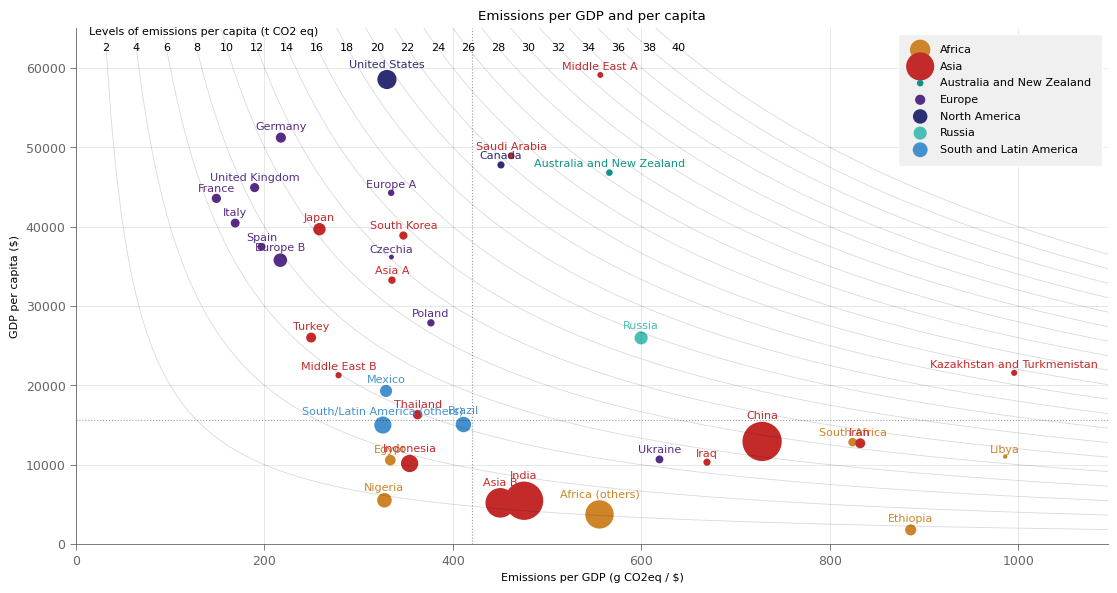

In [28]:
fig, ax = plt.subplots()

# normalization of bubble sizes
norm = plt.Normalize(df['pop'].min(), df['pop'].max())

# iterate over continents and plot the data with the right colors
for continent, cdf in df.groupby('continent'):
    sns.scatterplot('ghg_per_gdp', 'gdp_per_capita', data=cdf, color=color_schema[continent], label=continent, size='pop',
                    sizes=(10, 800), size_norm=norm, legend=False, ec=None)
    # country labels
    for i, row in cdf.iterrows():
        plt.text(row['ghg_per_gdp'], row['gdp_per_capita'] + 100 + np.sqrt(row['pop']) / 15, row['region'],
                 color=color_schema[continent], ha='center', va='bottom')

# set the plot limits
xmax = df['ghg_per_gdp'].max() * 1.1
ymax = df['gdp_per_capita'].max() * 1.1
ax.set(xlim=(0, xmax), ylim=(0, ymax))

# add hyperbolas
xs = np.linspace(10, xmax, 200)
for i in list(range(2, 41, 2)):
    ys = 1e6 * i / xs
    sns.lineplot(xs, ys, lw=0.6, alpha=0.15, color='black')
    plt.text(1e6 * i / 6.25e4, 6.25e4, str(i), color='black', ha='center', va='center')

# plot the world averages
ax.axvline(avg_ghg_per_gdp, color='black', alpha=0.4, linestyle=':')
ax.axhline(avg_gdp_per_capita, color='black', alpha=0.4, linestyle=':')

# add titles and descriptions
plt.text(1e6 / 6e4 - 3, 6.45e4, 'Levels of emissions per capita (t CO2 eq)', color='black', ha='left', va='center')
ax.set(xlabel='Emissions per GDP (g CO2eq / $)', ylabel='GDP per capita ($)',
       title='Emissions per GDP and per capita')

plt.show()

Matplotlib also allows to save the chart as PDF or SVG. These vector formats can then be loaded into a specialized graphic software such as Illustrator or Inkscape to turn them into a nice, proper visualization that can be found on our website.